In [186]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as pt
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

#loading input data 
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")

combine=pd.concat([train.drop('Survived',1),test])
# Any results you write to the current directory are saved as output.
train.head()

gender_submission.csv
test.csv
train.csv



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**FEATURE ANALYSIS**

Pclass is the Ticket-class: first (1), second (2), and third (3) class tickets were used. This is an ordinal integer feature.

Name is the name of the passenger. The names also contain titles and some persons might share the same surname; indicating family relations. We know that some titles can indicate a certain age group. For instance Master is a boy while Mr is a man. This feature is a character string of variable length but similar format.

Sex is an indicator whether the passenger was female or male. This is a categorical text string feature.

Age is the integer age of the passenger. There are NaN values in this column.

SibSp is another ordinal integer feature describing the number of siblings or spouses travelling with each passenger.

Parch is another ordinal integer features that gives the number of parents or children travelling with each passenger.

Ticket is a character string of variable length that gives the ticket number.

Fare is a float feature showing how much each passenger paid for their rather memorable journey.

Cabin gives the cabin number of each passenger. There are NaN in this column. This is another string feature.

Embarked shows the port of embarkation as a categorical character value.

In [187]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**MISSING VALUES**

In [188]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

test.isnull().sum()

In [189]:
surv=train[train['Survived']==1]
nosurv=train[train['Survived']==0]
#finding the percentage of survival
print ("survived perc %f" %(len(surv)/len(train)*100))
print ("not survived perc %.1f" %(len(nosurv)/len(train)*100))
surv_col="Green"
nosurv_col="Red"

survived perc 38.383838
not survived perc 61.6


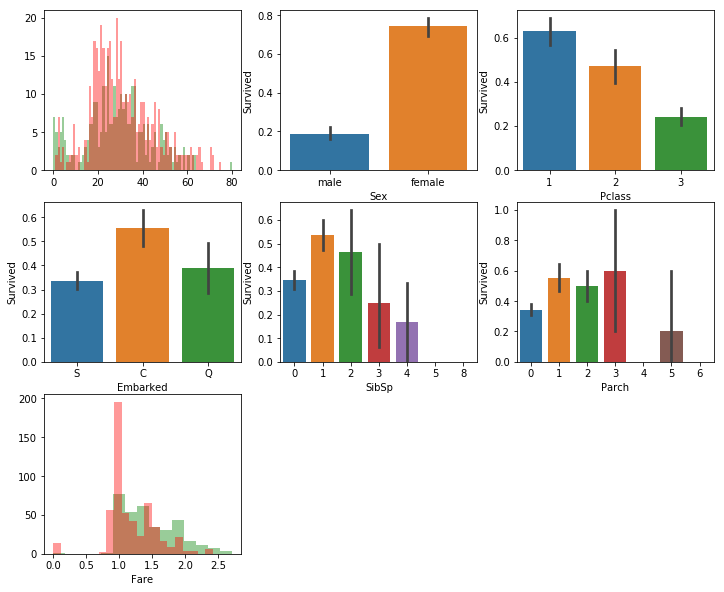

In [190]:
pt.figure(figsize=[12,10])
pt.subplot(331)
sns.distplot(surv['Age'].dropna().values,bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values,bins=range(0, 81, 1), kde=False, color=nosurv_col)
#obs: neither no infants(<1) nor the aged died 
pt.subplot(332)
sns.barplot('Sex','Survived',data=train)
#obs: Mostly female survived
pt.subplot(333)
sns.barplot('Pclass','Survived',data=train)
#obs: higher class people survived mostly
pt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
#obs: people who embarked through C has higher survival rate
pt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
#obs:people with singe sibling have higher survival rate
pt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
pt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna()+1),kde=False,color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna()+1),kde=False,color=nosurv_col)
#obs: highest fare people have survived and people with 0 fare have died


In [191]:
pd.crosstab(train['Embarked'],train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


**Understand cabin**

In [192]:
#Cabin is albhanumeric, contains missing values, and we have to see how it is related to survival
print("There are cabins %i/%i in train"%(len(train['Cabin'].dropna()),len(train)))
print("There are cabins %i/%i in test"%(len(test['Cabin'].dropna()),len(test)))
#find unique value count
print("Unique train cabin numbers are %i"%(len(train['Cabin'].dropna().unique())))
print("Unique test cabin numbers are %i"%(len(test['Cabin'].dropna().unique())))

There are cabins 204/891 in train
There are cabins 91/418 in test
Unique train cabin numbers are 147
Unique test cabin numbers are 76


In [193]:
train.loc[:,['Survived','Cabin']].head(10)
#obs: some people have missing cabin/more than one cabin numbers

,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN
5,0,NaN
6,0,E46
7,0,NaN
8,1,NaN
9,1,NaN


**TICKET NUMBERS**

In [194]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [195]:
train['Ticket'].isnull().sum()
#obs: everyone had ticket
print ("there are %i unique tickets out of %i tickets"%(train['Ticket'].nunique(),len(train)))
#So a tikcet has been shared with people
grouped=train.groupby('Ticket')
for key,value in grouped:
    if (len(grouped.get_group(key))>1):
        print (value.loc[:,['Survived','Name','Fare']])

there are 681 unique tickets out of 891 tickets
     Survived                                               Name  Fare
257         1                               Cherry, Miss. Gladys  86.5
504         1                              Maioni, Miss. Roberta  86.5
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  86.5
     Survived                                    Name   Fare
262         0                       Taussig, Mr. Emil  79.65
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  79.65
585         1                     Taussig, Miss. Ruth  79.65
     Survived                            Name  Fare
110         0  Porter, Mr. Walter Chamberlain  52.0
475         0     Clifford, Mr. George Quincy  52.0
     Survived                                             Name     Fare
329         1                     Hippach, Miss. Jean Gertrude  57.9792
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fischer)  57.9792
     Survived                                    Nam

     Survived                                       Name  Fare
272         1  Mellinger, Mrs. (Elizabeth Anne Maidment)  19.5
446         1          Mellinger, Miss. Madeleine Violet  19.5
     Survived                   Name  Fare
714         0  Greenberg, Mr. Samuel  13.0
800         0   Ponesell, Mr. Martin  13.0
     Survived                             Name  Fare
247         1  Hamalainen, Mrs. William (Anna)  14.5
755         1        Hamalainen, Master. Viljo  14.5
     Survived                                               Name  Fare
427         1  Phillips, Miss. Kate Florence ("Mrs Kate Louis...  26.0
705         0     Morley, Mr. Henry Samuel ("Mr Henry Marshall")  26.0
     Survived                   Name     Fare
114         0  Attalah, Miss. Malake  14.4583
495         0  Yousseff, Mr. Gerious  14.4583
     Survived                                           Name  Fare
506         1  Quick, Mrs. Frederick Charles (Jane Richards)  26.0
530         1                       Qu

777         1  Emanuel, Miss. Virginia Ethel  12.475
     Survived                           Name  Fare
188         0               Bourke, Mr. John  15.5
657         0  Bourke, Mrs. John (Catherine)  15.5
     Survived                Name   Fare
301         1  McCoy, Mr. Bernard  23.25
330         1  McCoy, Miss. Agnes  23.25
     Survived                            Name  Fare
241         1  Murphy, Miss. Katherine "Kate"  15.5
612         1     Murphy, Miss. Margaret Jane  15.5
     Survived                                        Name      Fare
318         1                    Wick, Miss. Mary Natalie  164.8667
856         1  Wick, Mrs. George Dennick (Mary Hitchcock)  164.8667
     Survived                                             Name     Fare
496         1                   Eustis, Miss. Elizabeth Mussey  78.2667
591         1  Stephenson, Mrs. Walter Bertram (Martha Eustis)  78.2667
     Survived                                          Name    Fare
62          0              

665         0           Hickman, Mr. Lewis  73.5
     Survived                                               Name     Fare
43          1           Laroche, Miss. Simonne Marie Anne Andree  41.5792
608         1  Laroche, Mrs. Joseph (Juliette Marie Louise La...  41.5792
685         0             Laroche, Mr. Joseph Philippe Lemercier  41.5792
     Survived                                               Name   Fare
142         1  Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...  15.85
403         0                     Hakkarainen, Mr. Pekka Pietari  15.85
     Survived                                      Name   Fare
783         0                    Johnston, Mr. Andrew G  23.45
888         0  Johnston, Miss. Catherine Helen "Carrie"  23.45
     Survived                                     Name    Fare
86          0                   Ford, Mr. William Neal  34.375
147         0         Ford, Miss. Robina Maggie "Ruby"  34.375
436         0     Ford, Miss. Doolina Margaret "Daisy"  34.37

**FINDING RELATION BETWEEN FEATURES**

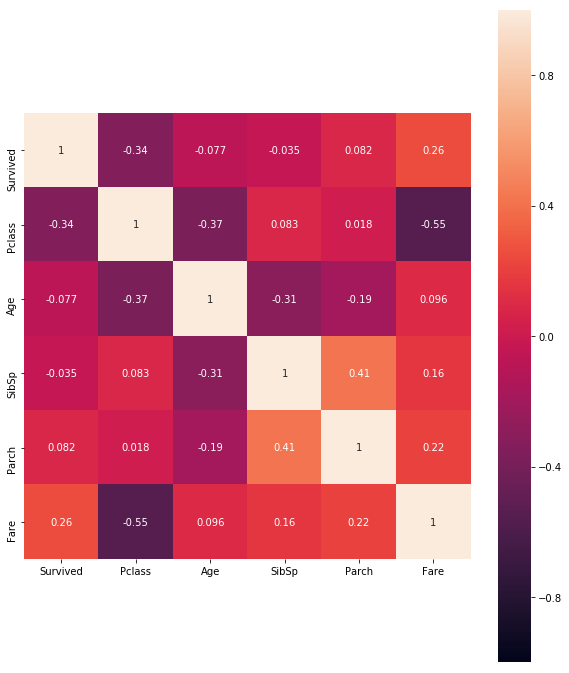

In [196]:
pt.figure(figsize=(10,12))
sns.heatmap(train.drop('PassengerId',axis=1).corr(),vmin=-1,vmax=1,square=True,annot=True)
#obs: fare and survived, Parch an dsurvived



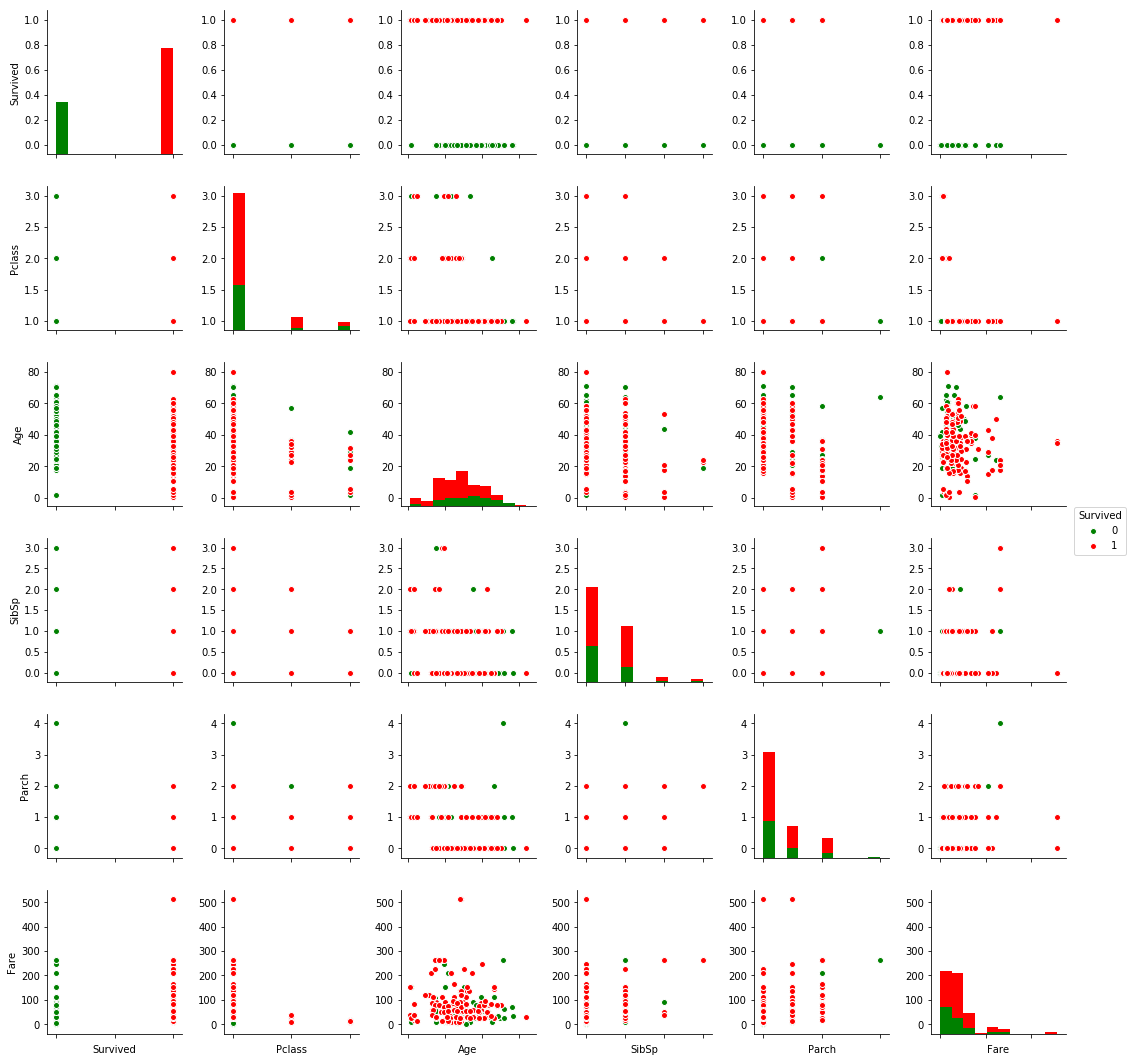

In [197]:
cols=['Survived','Pclass','Age','SibSp','Parch','Fare']
g=sns.pairplot(train.dropna(),hue='Survived',vars=cols,size=2.5,palette=[surv_col,nosurv_col])
g.set(xticklabels=[])

**correlations between the predictor features and how they could affect the target Survived behaviour.**

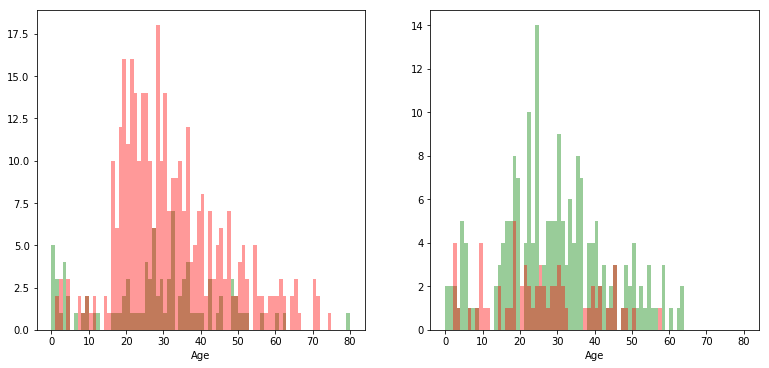

In [198]:
#Gender and survival
Msurv=train[(train['Sex']=="male")&(train['Survived']==1)]
Fsurv=train[(train['Sex']=="female")&(train['Survived']==1)]
Mnosurv=train[(train['Sex']=="male")&(train['Survived']==0)]
Fnosurv=train[(train['Sex']=="female")&(train['Survived']==0)]
pt.figure(figsize=(20,20))
pt.subplot(331)
sns.distplot(Msurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=surv_col)
sns.distplot(Mnosurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=nosurv_col)

pt.subplot(332)
sns.distplot(Fsurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=surv_col)
sns.distplot(Fnosurv['Age'].dropna(),bins=range(0, 81, 1),kde=False,color=nosurv_col)
#obs:
#boys have higher survival rate
#males between 15 - 75 less survival rate comparing to female

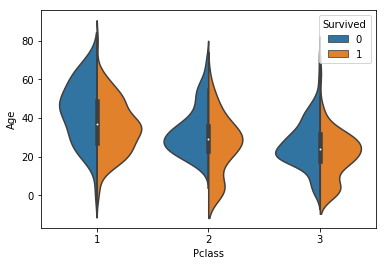

In [199]:
sns.violinplot(x=train['Pclass'],y=train['Age'],hue=train['Survived'],split=True)
#obs:

#1.Pclass 1: has older people, not survived
#2.Pclass 3: has very less older people,Children rate is high
#3.Pclass 2: children survial rate is high

In [200]:
mosaic(train,["Survived","Sex","Pclass"])

NameError: name 'mosaic' is not defined

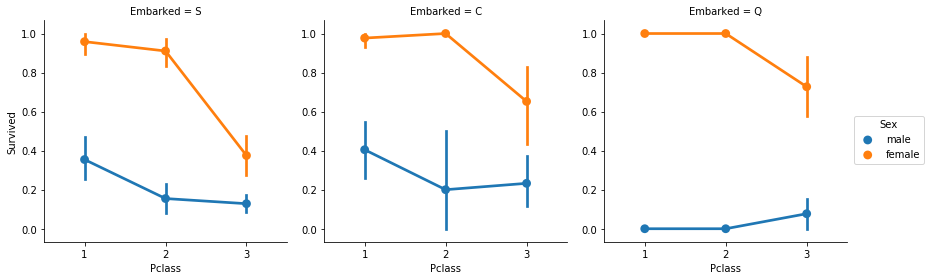

In [201]:
sns.factorplot(x="Pclass",y='Survived',hue='Sex',col='Embarked',data=train)
#obs:
#Male has lower survival,Female has lower survival in case of 3 class


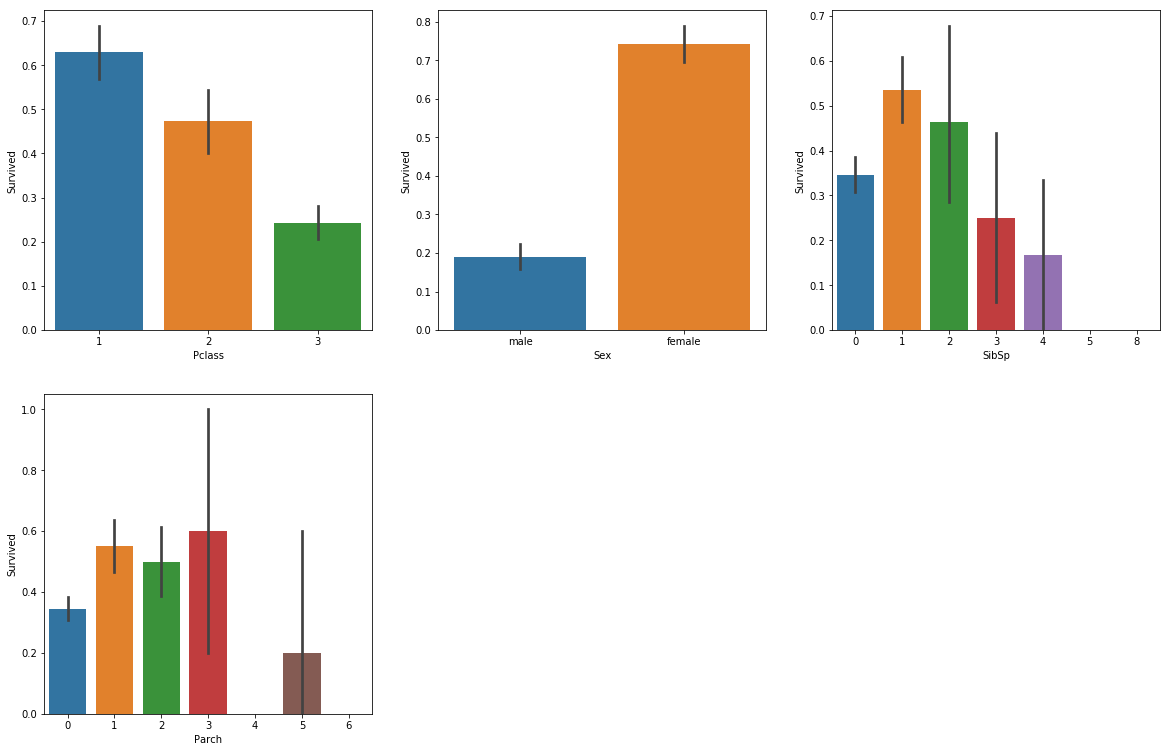

In [202]:
pt.figure(figsize=(20,20))
pt.subplot(331)
sns.barplot("Pclass","Survived",data=train)
pt.subplot(332)
sns.barplot("Sex","Survived",data=train)
pt.subplot(333)
sns.barplot("SibSp","Survived",data=train)
pt.subplot(334)
sns.barplot("Parch","Survived",data=train)

In [203]:
train[["Parch","Survived"]].groupby("Parch").mean().sort_values(by='Survived',ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


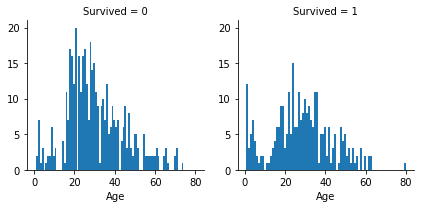

In [204]:
struct=sns.FacetGrid(data=train,col="Survived")
struct.map(pt.hist,"Age",bins=80)

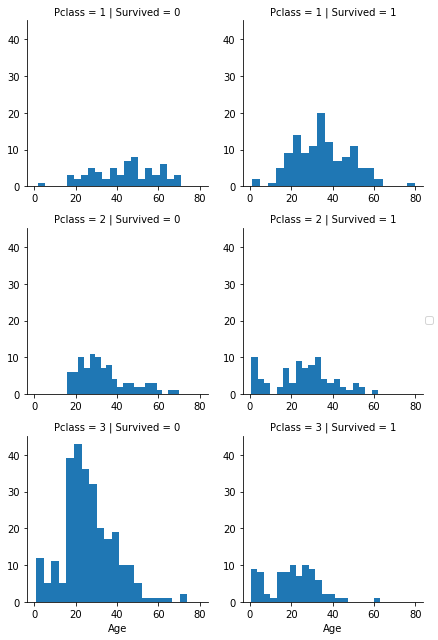

In [205]:
struct=sns.FacetGrid(data=train,col="Survived",row="Pclass")
struct.map(pt.hist,"Age",bins=20)
struct.add_legend()

**WRANGLE DATA**

In [206]:
#REMOVE USELESS COLUMNs
train=train.drop(['Ticket','Cabin'],axis=1)
test=test.drop(['Ticket','Cabin'],axis=1)


CREATING NEW FEATURES

In [207]:
train.head(10)
test['Title']=test['Name'].str.extract(' ([A-Za-z]+)\.')
train['Title']=train['Name'].str.extract(' ([A-Za-z]+)\.')



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [208]:
train['Title']=train['Title'].replace('Mlle', 'Miss')
train['Title']=train['Title'].replace('Ms', 'Miss')
train['Title']=train['Title'].replace('Mme', 'Mrs')
train['Title']=train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [209]:
test['Title']=test['Title'].replace('Mlle', 'Miss')
test['Title']=test['Title'].replace('Ms', 'Miss')
test['Title']=test['Title'].replace('Mme', 'Mrs')
test['Title']=test['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [210]:
title={'Master':1,'Miss':2,'Mr':3,'Mrs':4,'Rare':5}

In [211]:
train['Title']=train['Title'].map(title)
test['Title']=test['Title'].map(title)

In [212]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,4
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,3
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,4
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,3
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,2
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,3
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,4
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S,3


In [213]:
train=train.drop('Name',axis=1)
train=train.drop('PassengerId',axis=1)

In [214]:
train.info()

test=test.drop('Name',axis=1)
test=test.drop('PassengerId',axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [215]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
Title       418 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [216]:
#converting categorical features into numerical features
train['Sex']=train['Sex'].map({'male':0,'female':1}).astype(int)

In [217]:
test['Sex']=test['Sex'].map({'male':0,'female':1}).astype(int)

In [218]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 62.7+ KB


In [219]:
guess_ages = np.zeros((2,3))

In [220]:

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train[(train['Sex'] == i) & \
                              (train['Pclass'] == j+1)]['Age'].dropna()


        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        train.loc[ (train.Age.isnull()) & (train.Sex == i) & (train.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

train['Age'] = train['Age'].astype(int)

In [221]:
guess_ages = np.zeros((2,3))

In [222]:

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = test[(test['Sex'] == i) & \
                              (test['Pclass'] == j+1)]['Age'].dropna()


        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
        test.loc[ (test.Age.isnull()) & (test.Sex == i) & (test.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

test['Age'] = test['Age'].astype(int)

In [223]:
#create age bands
train['Ageband']=pd.cut(train['Age'],5)

In [224]:
train[['Ageband', 'Survived']].groupby(['Ageband'], as_index=False).mean().sort_values(by='Ageband', ascending=True)

,Ageband,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [225]:
train.loc[train['Age']<=16,'Age']=0
train.loc[(train['Age']>16)&(train['Age']<=32),'Age']=1
train.loc[(train['Age']>32)&(train['Age']<=48),'Age']=2
train.loc[(train['Age']>48)&(train['Age']<=64),'Age']=3
train.loc[(train['Age']>64)&(train['Age']<=80),'Age']=4

In [226]:
train['Age'].unique()
train=train.drop('Ageband',axis=1)


In [227]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,3
1,1,1,1,2,1,0,71.2833,C,4
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,4
4,0,3,0,2,0,0,8.0500,S,3
5,0,3,0,1,0,0,8.4583,Q,3
6,0,1,0,3,0,0,51.8625,S,3
7,0,3,0,0,3,1,21.0750,S,1
8,1,3,1,1,0,2,11.1333,S,4
9,1,2,1,0,1,0,30.0708,C,4


In [228]:
test['Ageband']=pd.cut(test['Age'],5)

test.loc[test['Age']<=16,'Age']=0
test.loc[(test['Age']>16)&(test['Age']<=32),'Age']=1
test.loc[(test['Age']>32)&(test['Age']<=48),'Age']=2
test.loc[(test['Age']>48)&(test['Age']<=64),'Age']=3
test.loc[(test['Age']>64)&(test['Age']<=80),'Age']=4
test['Age'].unique()
test=test.drop('Ageband',axis=1)
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,0,2,0,0,7.8292,Q,3
1,3,1,2,1,0,7.0000,S,4
2,2,0,3,0,0,9.6875,Q,3
3,3,0,1,0,0,8.6625,S,3
4,3,1,1,1,1,12.2875,S,4
5,3,0,0,0,0,9.2250,S,3
6,3,1,1,0,0,7.6292,Q,2
7,2,0,1,1,1,29.0000,S,3
8,3,1,1,0,0,7.2292,C,4
9,3,0,1,2,0,24.1500,S,3


In [229]:
train["FamilySize"]=train['SibSp']+train['Parch']+1

In [230]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,0,1,1,0,7.2500,S,3,2
1,1,1,1,2,1,0,71.2833,C,4,2
2,1,3,1,1,0,0,7.9250,S,2,1
3,1,1,1,2,1,0,53.1000,S,4,2
4,0,3,0,2,0,0,8.0500,S,3,1
5,0,3,0,1,0,0,8.4583,Q,3,1
6,0,1,0,3,0,0,51.8625,S,3,1
7,0,3,0,0,3,1,21.0750,S,1,5
8,1,3,1,1,0,2,11.1333,S,4,3
9,1,2,1,0,1,0,30.0708,C,4,2


In [231]:
train.loc[train['FamilySize']==1,'IsAlone']=1
train.loc[train['FamilySize']>1,'IsAlone']=0

In [232]:
train[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


In [233]:
train=train.drop(['FamilySize','SibSp','Parch'],axis=1)

In [234]:
test["FamilySize"]=test['SibSp']+test['Parch']+1
test.loc[test['FamilySize']==1,'IsAlone']=1
test.loc[test['FamilySize']>1,'IsAlone']=0
#test[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values(by='Survived', ascending=False)
test=test.drop(['FamilySize','SibSp','Parch'],axis=1)

In [235]:
freq_port = train.Embarked.dropna().mode()[0]

In [236]:
train.Embarked=train.Embarked.fillna(freq_port)
test.Embarked=test.Embarked.fillna(freq_port)

In [237]:
train.Embarked.isnull().sum()

0

In [238]:
train.Embarked=train.Embarked.map({'S':0,'C':1,'Q':2}).astype(int)

In [239]:
test.Embarked=test.Embarked.map({'S':0,'C':1,'Q':2}).astype(int)

In [240]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

In [241]:
train['FareBand']=pd.qcut(train['Fare'],4)

In [242]:
train[['FareBand','Survived']].groupby(('FareBand'), as_index=False).mean().sort_values(by='FareBand',ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [243]:
train.loc[train['Fare']<=7.91,'Fare']=0
train.loc[(train['Fare']>7.91) & (train['Fare']<=14.454),'Fare']=1
train.loc[(train['Fare']>14.454) & (train['Fare']<=31.0),'Fare']=2
train.loc[(train['Fare']>31.0) & (train['Fare']<=512.329),'Fare']=3

In [244]:
test.loc[test['Fare']<=7.91,'Fare']=0
test.loc[(test['Fare']>7.91) & (test['Fare']<=14.454),'Fare']=1
test.loc[(test['Fare']>14.454) & (test['Fare']<=31.0),'Fare']=2
test.loc[(test['Fare']>31.0) & (test['Fare']<=512.329),'Fare']=3

In [245]:
train = train.drop(['FareBand'], axis=1)

**MODEL, PREDICT**

In [247]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

**Logistic Regression **

In [248]:
logistic=LogisticRegression()
logistic.fit(X_train,Y_train)
Y_test=logistic.predict(X_test)
accur_log=round(logistic.score(X_train, Y_train) * 100, 2)
print (accur_log)

79.8


In [250]:
svc=SVC()
svc.fit(X_train,Y_train)
Y_test=svc.predict(X_test)
accur_svc=round(svc.score(X_train,Y_train)*100,2)
print (accur_svc)

82.49


In [251]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
Y_test=knn.predict(X_test)
accur_knn=round(knn.score(X_train,Y_train)*100,2)
print(accur_knn)

77.33


In [252]:
nb=GaussianNB()
nb.fit(X_train,Y_train)
Y_test=nb.predict(X_test)
accur_nb=round(nb.score(X_train,Y_train)*100,2)
print(accur_nb)

72.5


In [253]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
accur_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
accur_perceptron

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


76.090000000000003

In [254]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.459999999999994

In [255]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


77.329999999999998

In [256]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.760000000000005

In [257]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.760000000000005

In [258]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [accur_svc, accur_knn, accur_log, 
              acc_random_forest, accur_nb, accur_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
0,Support Vector Machines,82.49
2,Logistic Regression,79.80
7,Linear SVC,79.46
1,KNN,77.33
6,Stochastic Gradient Decent,77.33
5,Perceptron,76.09
4,Naive Bayes,72.50
